# Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling

In [1]:
import pandas as pd
import spacy
from spacy import displacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models

nlp = spacy.load("en_core_web_sm")
sou = pd.read_csv("data/SOTU.csv")

/home/jovyan/.local/share/envs/sotu/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Latent Dirichlet Allocation (LDA)

LDA is the most popular topic modeling algorithm in natural language processing. It utilizes a "bag of words" which give the frequency of tokens throughout all of the speeches to determine topics. We can then represent each speech as a probabilistic distribution of these topics. 

In [2]:
def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]

In [3]:
# Process all speeches - note that this takes ~ 5 minutes to run
processed_docs = sou['Text'].apply(preprocess_text)

In [4]:
processed_docs

0      [speak, president, present, prepared, remark, ...
1      [president, speaker, point, president, turn, f...
2      [president, thank, thank, thank, madam, speake...
3      [president, thank, thank, thank, good, mitch, ...
4      [president, thank, thank, thank, madam, speake...
                             ...                        
241    [fellow, citizen, senate, house, representativ...
242    [fellow, citizen, senate, house, representativ...
243    [fellow, citizen, senate, house, representativ...
244    [fellow, citizen, senate, house, representativ...
245    [fellow, citizen, senate, house, representativ...
Name: Text, Length: 246, dtype: object

___
The dictionary assigns an id to each token. We filter out low-frequency and high-frequency tokens, and limit our dictionary to just 1000 tokens. 

In [42]:
# This results in 22652 unique tokens - we filter out extreme values and set the max number of tokens to 1000
# Question: do we need to set a max number of tokens?
dictionary = Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.5)

___
We now build the corpus by counting the frequency of each token in our dictionary within all of the speeches, and we return the result as a sparse vector. 

We train the model based on this information, and specify that we want 18 topics. The corpus is analyzed to find the distribution of tokens in each topic and the distribution of topics in each document. The distribution of tokens in each topic is also printed below. 

In [43]:
# train LDA model with 18 topics
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=18, passes=10, random_state = 42)

In [44]:
# print the top 10 words for each topic
lda_model.print_topics()

[(0,
  '0.004*"cent" + 0.004*"june" + 0.004*"gold" + 0.003*"island" + 0.003*"silver" + 0.003*"bond" + 0.003*"method" + 0.003*"convention" + 0.003*"indian" + 0.003*"note"'),
 (1,
  '0.008*"depression" + 0.007*"program" + 0.007*"recovery" + 0.006*"budget" + 0.006*"unemployment" + 0.006*"loan" + 0.006*"activity" + 0.006*"farm" + 0.005*"emergency" + 0.005*"cent"'),
 (2,
  '0.008*"dictator" + 0.005*"expression" + 0.004*"british" + 0.004*"1914" + 0.003*"impressive" + 0.003*"actual" + 0.003*"revolution" + 0.003*"schedule" + 0.003*"continent" + 0.003*"partisanship"'),
 (3,
  '0.008*"forest" + 0.007*"corporation" + 0.005*"judge" + 0.005*"wrong" + 0.005*"interstate" + 0.004*"employee" + 0.003*"bureau" + 0.003*"body" + 0.003*"mountain" + 0.003*"island"'),
 (4,
  '0.017*"program" + 0.014*"soviet" + 0.009*"1980" + 0.009*"u.s." + 0.008*"area" + 0.007*"major" + 0.006*"goal" + 0.006*"commitment" + 0.006*"challenge" + 0.006*"nuclear"'),
 (5,
  '0.015*"americans" + 0.014*"tonight" + 0.007*"thank" + 0.00

___
The cell below and output tells us that the first speech in our dataset (the most recent one given by President Biden in 2024) is 99.9% likely to belong to Topic #11. This topic includes words such as "americans", "tonight", "percent", "thank", "worker", "iraq", "democracy", "fight", "terrorist", and "challenge." 

In [45]:
# print the topic distribution for the first speech
lda_model[corpus][0]

[(11, np.float32(0.99942815))]

___
We can visualize the topics, relationships between topics, and the most important words for each topics using pyLDAvis, as shown below. 

In [46]:
# make a visualization using pyLDAvis
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [21]:
pyLDAvis.save_html(lda_display,'outputs/03_01_LDA_topics.html')

#### Initial observations from LDA 

From the pyLDAvis visualization, we can see the size and distribution of topics, as well as relations to one another. The size of the circles for each topic represent the prevalence of each topic within all of our speeches. If we hover over a topic, or use the topic selector in the top left, we can see the most common tokens for that topic on the right side of the visualization. 

For instance, topics 1 and 2 have some overlap, and seem to be related to older speeches, inclusing words such as convention, Spain, and Indians (likely referring to Native Americans). Topics 6 and 7 seem to be more specific subsets of topic 2 in particular, and discuss Mexico as well as specific states like Texas, California, and Kansas. Topics 5, 8, 12, and 13 are also clustered and seem to describe more domestic topics such as railroad, interstate, agricultural, farmer, corporation, and industrial. Topics 4, 10 and 11 are more closely related, with the most frequent token for all three topics being "program". Topics 3, 9, and 14 also seem to be more closely related, with primary tokens such as "Americans" and "tonight", as well as discussing more recent foreign policy topics such as Iraq and terrorists. Topics 15 - 18 are very small and not very prevalent among the speeches. 

____
### BERTopic

BERTopic is another method for topic modeling. It approaches topic modeling as a cluster task and attempts to cluster semantically similar documents to extract common topics. 

In [22]:
docs = sou['Text'].to_list()

In [33]:
# train the model - this takes about 30 seconds
topic_model = BERTopic(min_topic_size=3)
topics, probs = topic_model.fit_transform(docs)

# remove stop words from the topics
vectorizer_model = CountVectorizer(stop_words="english")
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

___
The code cell and output below show the top ten words in each BERTopic topic. Note that we only set a minimum topic size, but no maximum topic size, so we get a different number of topics than we did when using LDA. Here we have 23, where before we had 18. 

In [37]:
# output the top 10 words for each topic
pd.set_option("display.max_colwidth", None)
topic_model.get_topic_info()['Representation']

0                              [government, states, united, congress, year, people, new, war, country, great]
1                 [states, government, united, congress, public, great, year, subject, country, constitution]
2                         [states, government, public, united, congress, country, present, year, time, state]
3                      [government, united, states, department, congress, great, public, service, law, shall]
4                          [world, nations, soviet, peace, economic, free, military, defense, nation, people]
5                               [world, american, president, people, america, war, nation, new, years, great]
6                              [america, american, americans, people, tonight, jobs, know, going, new, years]
7                       [government, work, great, public, law, congress, country, national, business, people]
8                   [government, states, public, united, subject, general, congress, country, present, state]
9         

___
Below we can see the probability distribution for the first speech. There is more uncertainty in the topic distribution here as there was in LDA (where we had 99.9% certainty it belonged to a given topic). The first speech seems most likely to belong to topic #5, which includes tokens like "america", "american", "americans", "people", "tonight", "jobs", "know", "going", "new", and "years."

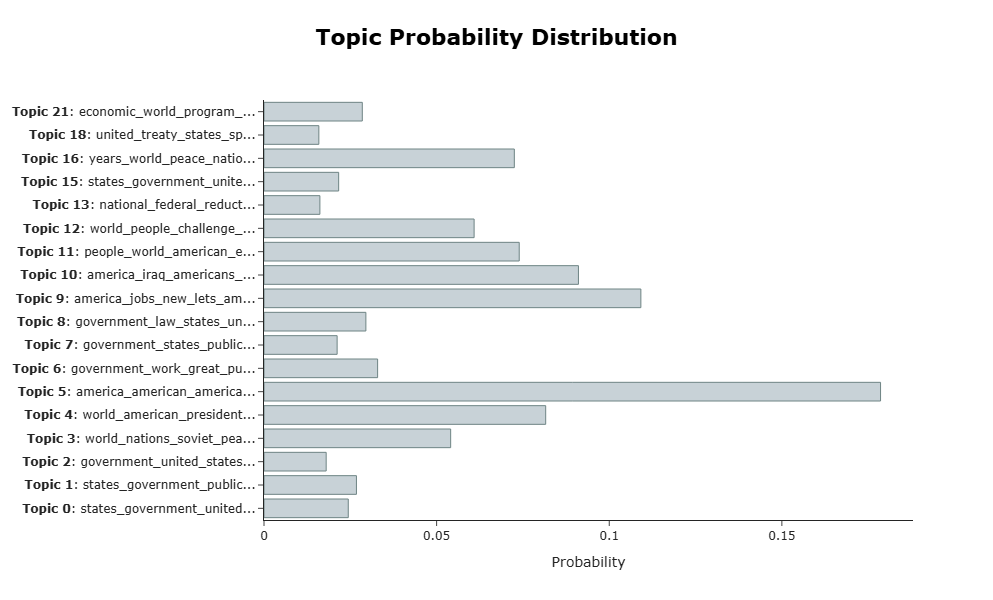

In [35]:
# output the topic distribution for the first speech
topic_distr, _ = topic_model.approximate_distribution(docs)
first_speech = topic_model.visualize_distribution(topic_distr[1])

#save first speech topic distribution to outputs
first_speech.write_html("outputs/03_01_BERTopic_first_speech.html")
first_speech

___
The visualization below gives the clusters of topics, similar to as we saw with the LDA topics above. Here, however, we do not have the tab on the right that shows token frequency within a topic. If we hover over a topic, we can see the first few tokens which are associated with that topic. Topics in the top left portion of the chart seem to be more related to economic productivity, jobs, and foreign diplomacy. Most of the topics on the right portion of the graph all seem to have "government," "states," "public," and  "united" as common terms. Topics on the bottom portion of the chart all relate to "people," "world," and "america(ns)."

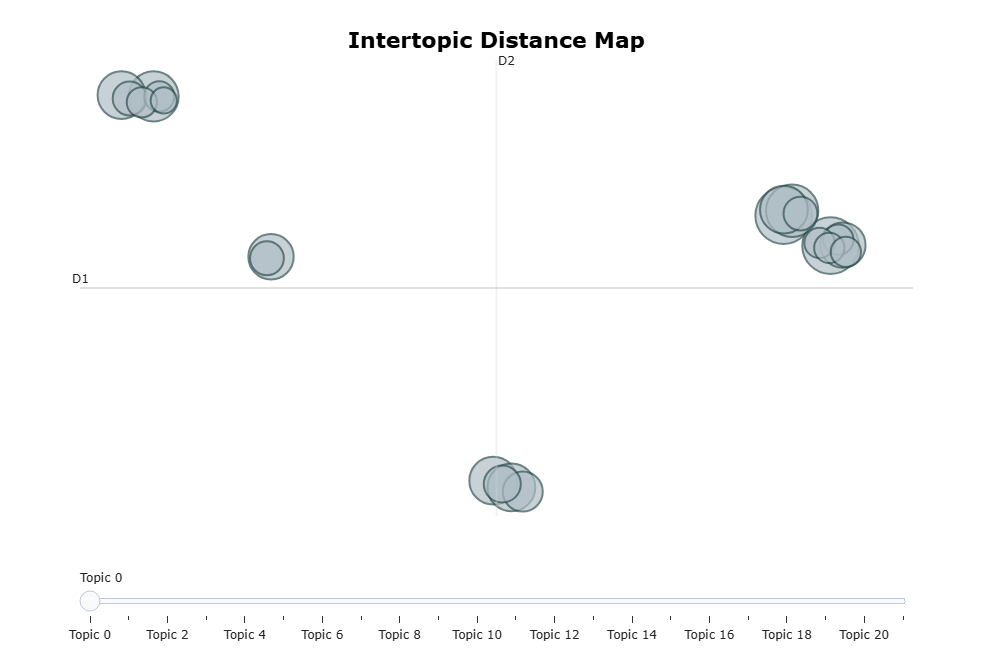

In [36]:
# run this cell to visualize the topics
topic_model.visualize_topics()

___
#### LDA versus BERTopic for topic modeling

Both LDA (through Bag of Words) and BERTopic (through semantic segmentation) provide compelling ways to identify specific topics within the presidential speeches we analyze here. LDA provided more specific topics than BERTopic, which had many reused tokens that made it hard to identify differences among topics. This is likely because we were able to remove the highest and lowest frequency tokens, which gave us more specificity in the topics we identified through LDA. Since we did not clean the data in a similar way with BERTopic, this may have given us less specific topics. The visualization for LDA also provided more information on the topics themselves, based on the frequencies of each word by topic. BERTopic only allowed us to see the terms by hovering over the topic circles, and then only gave us the top terms without the distributions, as LDA did. Finally, we did not set a random state for BERTopic, which is a stochastic modeling process, so rerunning the script gives us different results each time. Though the LDA model is also stochastic, we set a random state for this model we get reliable results each time. 